In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from copy import deepcopy
from scipy import stats

from sklearn import model_selection, preprocessing, linear_model, neighbors, ensemble, tree, neural_network, metrics, impute
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

from utils import classification_util as cu
from utils import data_preprocessing_util as dpu

# Data Preparation

In [23]:
data_path = r'data/Breast_Cancer/breast-cancer-diagnostic.shuf.lrn.csv'
df = pd.read_csv(data_path)

Dataset does not contain any missing values:

In [24]:
na_counts = df.isna().sum() / len(df)
print(f'Columns with missing values: {na_counts[na_counts > 0.0]}')

Columns with missing values: Series([], dtype: float64)


In [25]:
feat_cols = df.columns.difference(['ID', 'class'])

Some of the variables are skewed and contain potential outliers:

/var/folders/tc/kb5gq8ms7xv2tdf3j0y_5yzh0000gn/T/ipykernel_62847/1639552964.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = df[feat_cols].hist(ax=axes)


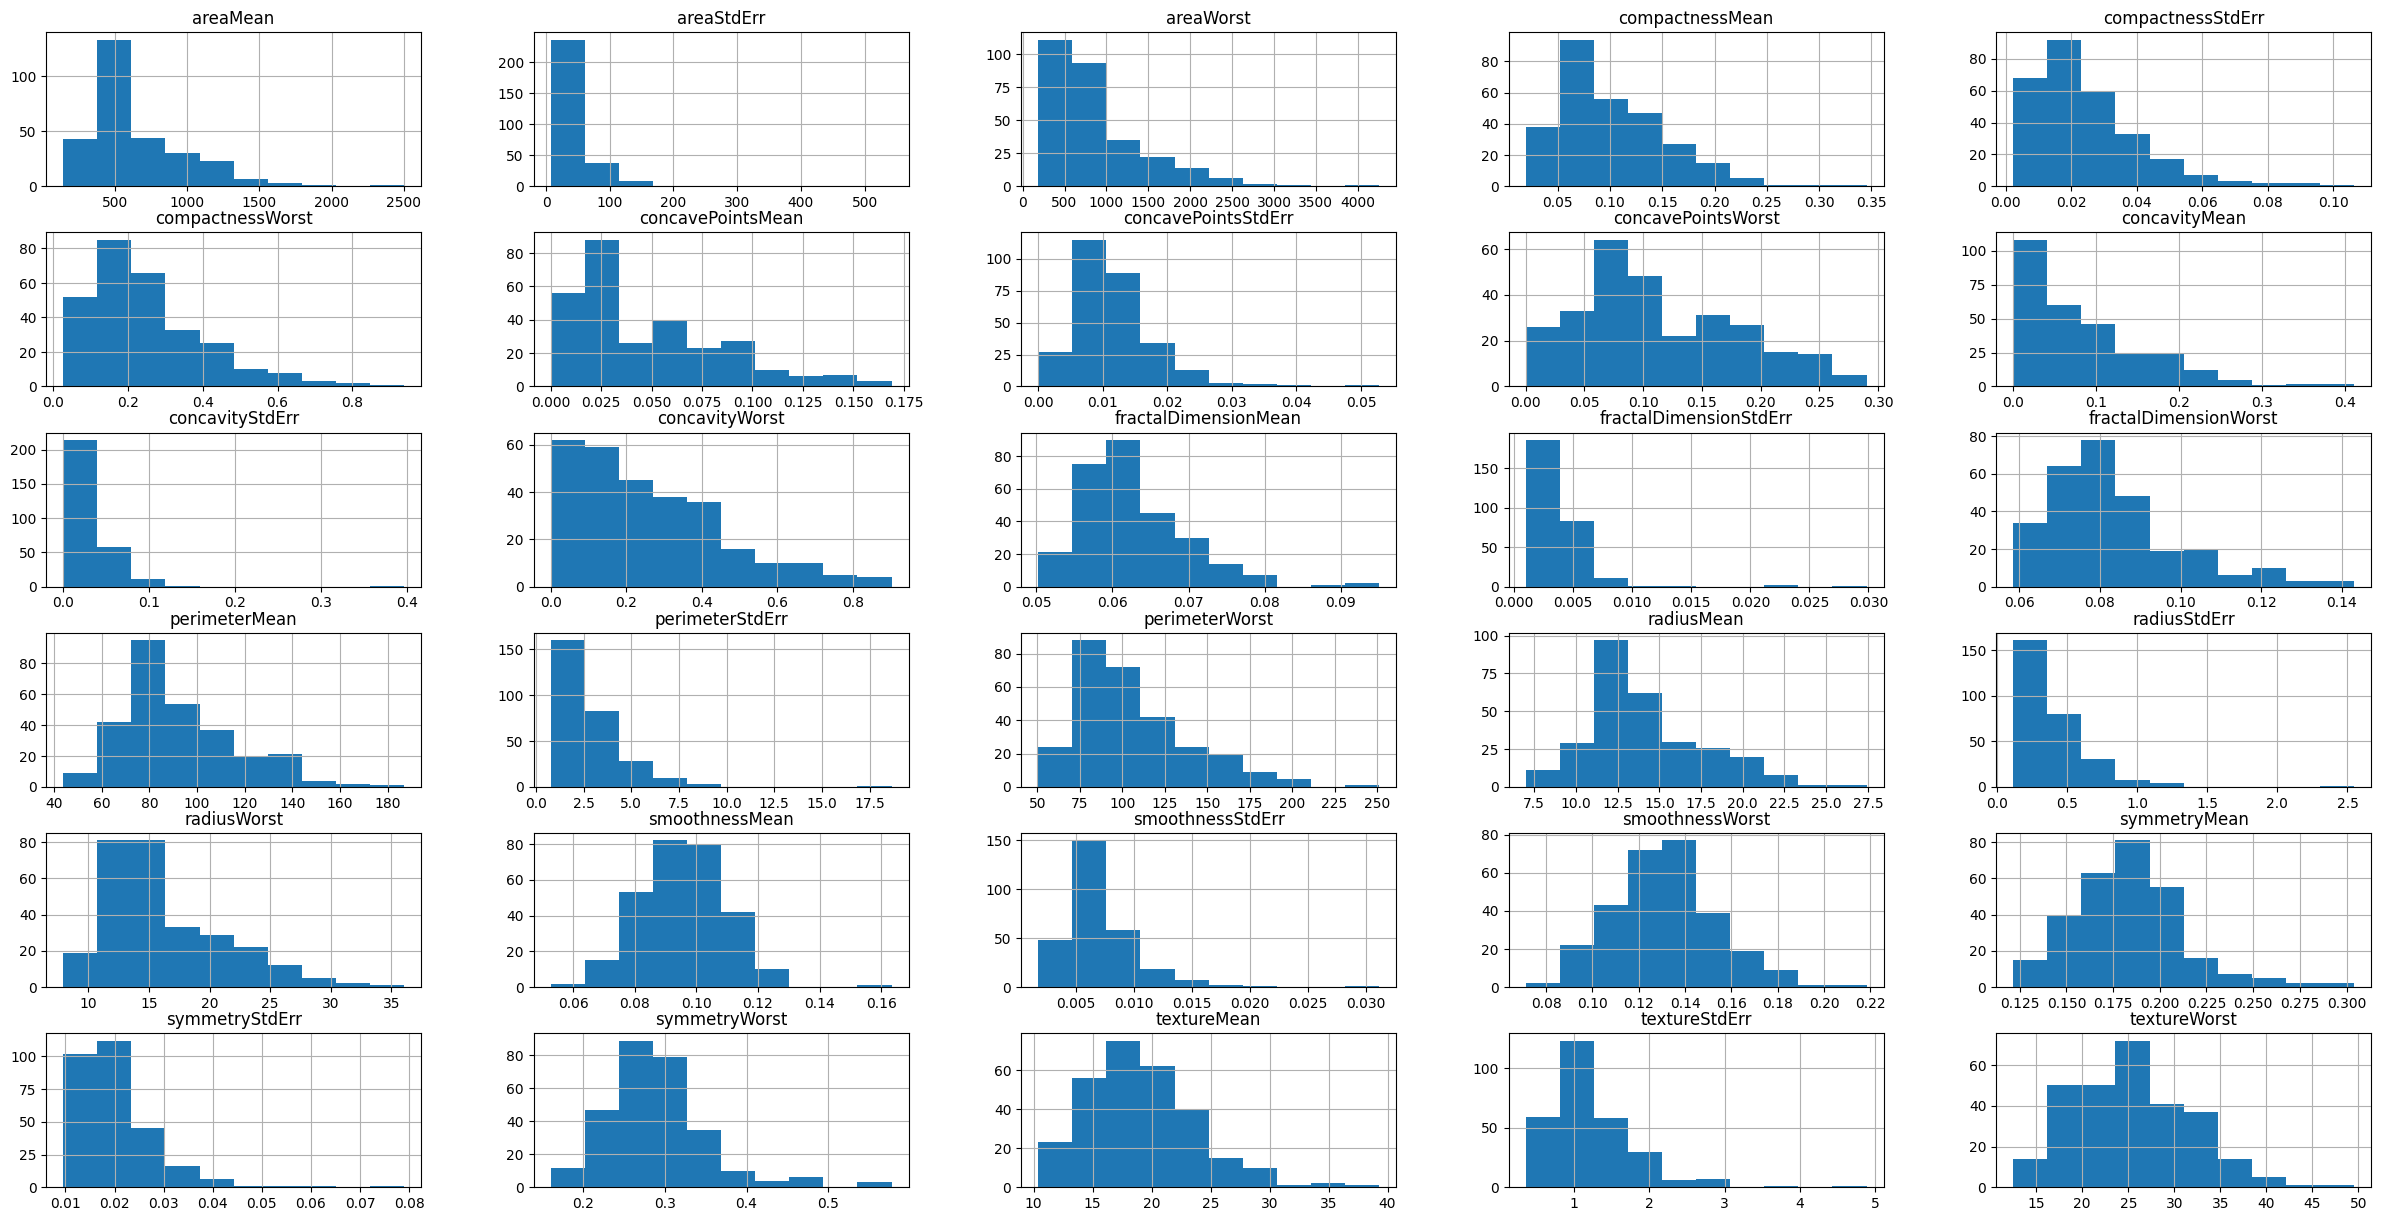

In [14]:
_, axes = plt.subplots(figsize=(30, 15))
_ = df[feat_cols].hist(ax=axes)

In [119]:
df.describe()

,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
count,2.850000e+02,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,2.861498e+07,14.068674,19.116211,91.555053,649.617895,0.095851,0.102605,0.085587,0.047930,0.182908,...,16.214354,25.568737,106.866175,878.226316,0.131940,0.251042,0.263251,0.113729,0.291636,0.083341
std,1.204247e+08,3.486377,4.516754,24.028687,343.979266,0.013894,0.051422,0.075717,0.037409,0.028606,...,4.820742,6.318778,33.390308,572.257246,0.022377,0.153795,0.199783,0.067461,0.062957,0.016335
min,8.670000e+03,6.981000,10.380000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.121500,...,7.930000,12.490000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.160300,0.058430
25%,8.711490e+05,11.690000,15.900000,74.680000,418.700000,0.086000,0.062190,0.026880,0.020690,0.162100,...,13.010000,20.720000,84.160000,515.300000,0.116600,0.141500,0.111700,0.064130,0.250600,0.071910
50%,9.065390e+05,13.280000,18.700000,86.100000,546.400000,0.095140,0.092280,0.061950,0.033260,0.181400,...,14.970000,25.410000,97.820000,684.500000,0.131200,0.215800,0.217700,0.099750,0.284100,0.079570
75%,8.811523e+06,16.070000,21.840000,105.800000,797.800000,0.105100,0.130400,0.122600,0.073400,0.197600,...,19.070000,30.280000,126.300000,1124.000000,0.144000,0.323500,0.382900,0.162800,0.319800,0.090750
max,9.113205e+08,27.420000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.410800,0.168900,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.218400,0.937900,0.901900,0.290300,0.577400,0.143100


In data preprocessing:
- log-transform stdErr and 'areaWorst', 'compactnessWorst', 'compactnessMean', 'concavityMean', 'concavePointsMean', 'concavityWorst' columns to get less skewed distributions.
- Remove outliers by filtering out the rows if they contain values farther than 3 standard deviations from the mean:

The data preprocessing is not perfect, some of the variables are still skewed, but distributions look better than before.

In [15]:
df_preprocessed = dpu.preprocess_breast_cancer_data(df, log_transform=True, outlier_removal=True)

/var/folders/tc/kb5gq8ms7xv2tdf3j0y_5yzh0000gn/T/ipykernel_62847/1781503821.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = df_preprocessed[feat_cols].hist(ax=axes)


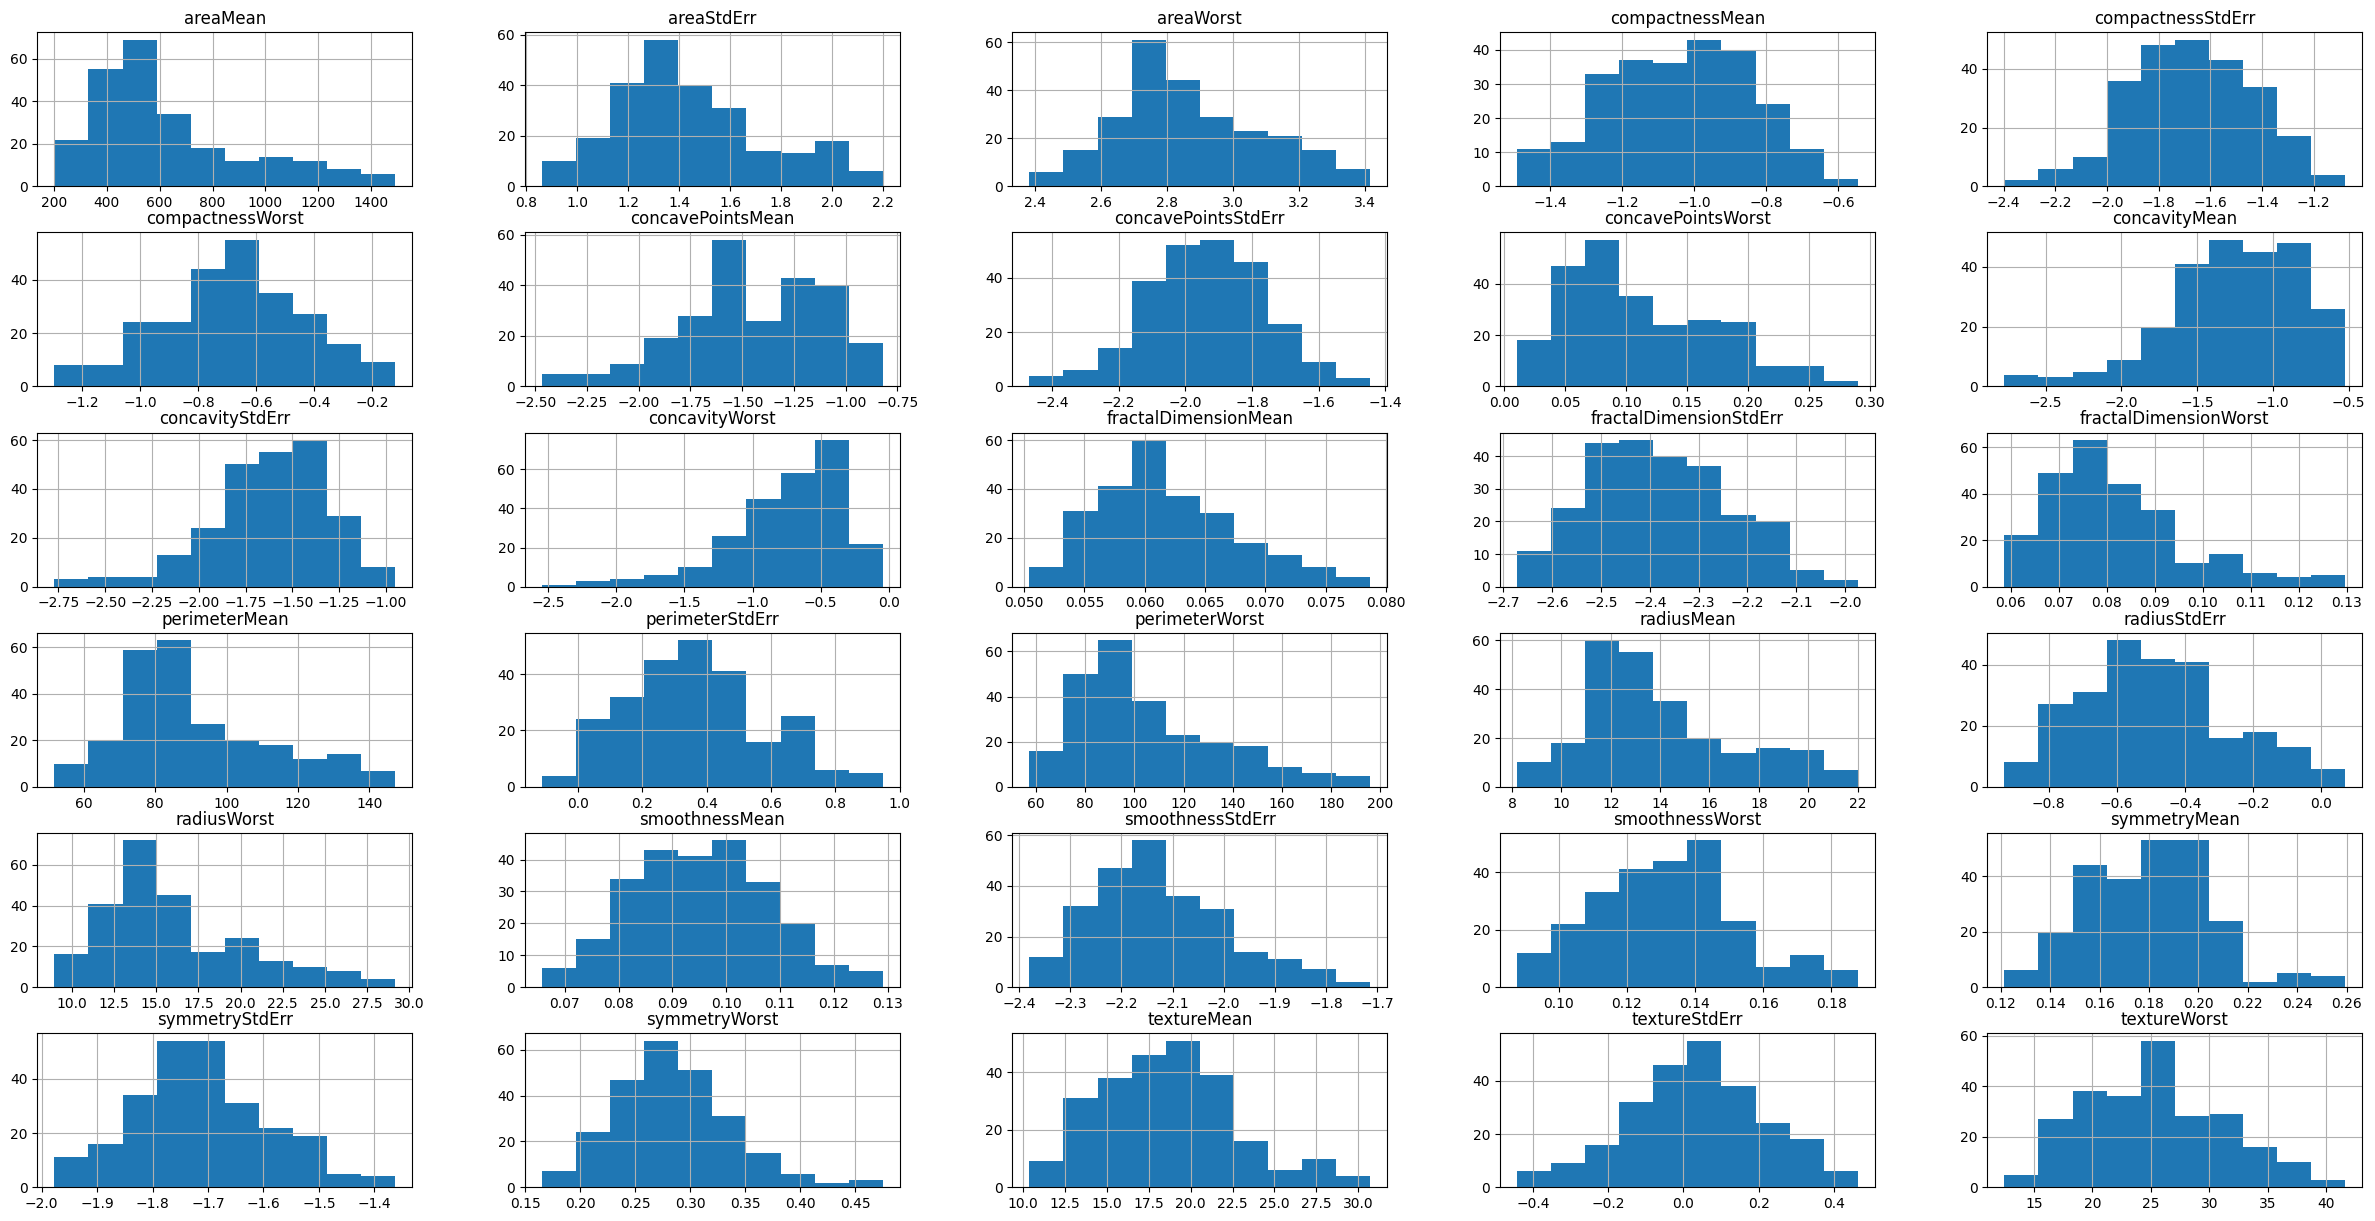

In [16]:
_, axes = plt.subplots(figsize=(30, 15))
_ = df_preprocessed[feat_cols].hist(ax=axes)

# Classification

In [26]:
data_path = r'data/Breast_Cancer/breast-cancer-diagnostic.shuf.lrn.csv'
df_original = pd.read_csv(data_path)

In [27]:
random_seed = 32
log_transform = True
outlier_removal = True
scaling = True
holdout = False

scaler = preprocessing.StandardScaler() if scaling else None

In [28]:
df = dpu.preprocess_breast_cancer_data(df_original, log_transform=log_transform, outlier_removal=outlier_removal)

In [29]:
y = df['class']
X = df[df.columns.difference(['ID', 'class'])]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)

if holdout:
    X_tr, _, _, _ = model_selection.train_test_split(X_train, y_train, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y_train)
    
    tr_val_split = y_train.copy()
    tr_val_split[:] = 0
    tr_val_split[X_tr.index.values] = -1
    
    cv = model_selection.PredefinedSplit(tr_val_split)

Initialize models to be tried out and their parameters:

In [33]:
methods = [
    ('KNN', neighbors.KNeighborsClassifier()), 
    ('DT', tree.DecisionTreeClassifier()), 
    ('MLP', neural_network.MLPClassifier())
    ]
    
pipelines = cu.define_pipelines(methods, scaler=scaler)

params = {}
params['KNN'] = {
    'KNN__n_neighbors' : [5, 10, 25, 50], 
    'KNN__p' : [1, 2]
}
params['DT'] = {
    'DT__criterion': ['gini', 'entropy', 'log_loss'],
    'DT__splitter': ['best', 'random'],
    'DT__class_weight': [None, 'balanced'],
    'DT__random_state': [random_seed],
}
params['MLP'] = {
    'MLP__hidden_layer_sizes': [(10,), (10, 10), (20), (20, 20,)], 
    'MLP__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLP__solver': ['lbfgs', 'adam', 'sgd'],
    'MLP__alpha': [0.001, 0.0001],
    'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLP__max_iter': [1000],
    'MLP__random_state': [random_seed],
}

### CV

In [34]:
model_cv = cu.compare_models(pipelines, params, X_train, y_train, X_test, y_test)

KNN
Best params: {'KNN__n_neighbors': 5, 'KNN__p': 1}
Best score: 0.9508338228857097
Refit time: 0.003898143768310547
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.16666667, 0.83333333]])

acc: 0.92
balanced_acc: 0.9010416666666667

Macro-averaged precision: 0.9246323529411764
Macro-averaged recall: 0.9010416666666667
Macro-averaged f-score: 0.910873440285205
Macro-averaged support: None
Report line: 0.920 0.901 0.925 0.901 0.911 0.004 
----------------------------------------------------------------------------------------------------
DT
Best params: {'DT__class_weight': 'balanced', 'DT__criterion': 'gini', 'DT__random_state': 32, 'DT__splitter': 'best'}
Best score: 0.9397867932207555
Refit time: 0.00925898551940918
Evaluation metrics:


array([[0.9375    , 0.0625    ],
       [0.22222222, 0.77777778]])

acc: 0.88
balanced_acc: 0.8576388888888888

Macro-averaged precision: 0.8786764705882353
Macro-averaged recall: 0.8576388888888888
Macro-averaged f-score: 0.8663101604278075
Macro-averaged support: None
Report line: 0.880 0.858 0.879 0.858 0.866 0.009 
----------------------------------------------------------------------------------------------------
MLP
Best params: {'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (20, 20), 'MLP__max_iter': 1000, 'MLP__random_state': 32}
Best score: 0.9671543137439832
Refit time: 1.6018288135528564
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.05555556, 0.94444444]])

acc: 0.96
balanced_acc: 0.9565972222222222

Macro-averaged precision: 0.9565972222222222
Macro-averaged recall: 0.9565972222222222
Macro-averaged f-score: 0.9565972222222222
Macro-averaged support: None
Report line: 0.960 0.957 0.957 0.957 0.957 1.602 
----------------------------------------------------------------------------------------------------


### Holdout

In [112]:
model_holdout = cu.compare_models(pipelines, params, X_train, y_train, X_test, y_test, cv)

KNN
Best params: {'KNN__n_neighbors': 10, 'KNN__p': 1, 'KNN__weights': 'uniform'}
Best score: 1.0
Refit time: 0.008202075958251953
Evaluation metrics:


array([[1.   , 0.   ],
       [0.125, 0.875]])

acc: 0.9591836734693877
balanced_acc: 0.9375

Macro-averaged precision: 0.9714285714285714
Macro-averaged recall: 0.9375
Macro-averaged f-score: 0.9519607843137254
Macro-averaged support: None
Report line: 0.959 0.938 0.971 0.938 0.952 0.008 
----------------------------------------------------------------------------------------------------
DT
Best params: {'DT__class_weight': 'balanced', 'DT__criterion': 'gini', 'DT__random_state': 1038, 'DT__splitter': 'random'}
Best score: 0.9430199430199431
Refit time: 0.011085033416748047
Evaluation metrics:


array([[0.93939394, 0.06060606],
       [0.0625    , 0.9375    ]])

acc: 0.9387755102040817
balanced_acc: 0.9384469696969697

Macro-averaged precision: 0.9255514705882353
Macro-averaged recall: 0.9384469696969697
Macro-averaged f-score: 0.9314685314685315
Macro-averaged support: None
Report line: 0.939 0.938 0.926 0.938 0.931 0.011 
----------------------------------------------------------------------------------------------------
MLP
Best params: {'MLP__activation': 'identity', 'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (10, 10), 'MLP__learning_rate': 'constant', 'MLP__max_iter': 1000, 'MLP__random_state': 1038, 'MLP__solver': 'sgd'}
Best score: 1.0
Refit time: 0.2923738956451416
Evaluation metrics:


array([[0.96969697, 0.03030303],
       [0.        , 1.        ]])

acc: 0.9795918367346939
balanced_acc: 0.9848484848484849

Macro-averaged precision: 0.9705882352941176
Macro-averaged recall: 0.9848484848484849
Macro-averaged f-score: 0.9771561771561772
Macro-averaged support: None
Report line: 0.980 0.985 0.971 0.985 0.977 0.292 
----------------------------------------------------------------------------------------------------


# Kaggle classification

In [11]:
data_path = r'data/Breast_Cancer/breast-cancer-diagnostic.shuf.lrn.csv'
df = pd.read_csv(data_path)

random_seed = 1038
log_transform = False
outlier_removal = False
scaling = False

df = dpu.preprocess_breast_cancer_data(df_original, log_transform=log_transform, outlier_removal=outlier_removal)

y = df['class']
X = df[df.columns.difference(['ID', 'class'])]

In [12]:
test_df = pd.read_csv('data/Breast_Cancer/breast-cancer-diagnostic.shuf.tes.csv')
test_df = dpu.preprocess_breast_cancer_data(test_df, log_transform=True, outlier_removal=False)

X_test = test_df[test_df.columns.difference(['ID', 'class'])]

In [13]:
pipelines = {}
methods = [
    ('MLP_optimal', neural_network.MLPClassifier(
        activation = 'logistic', 
        alpha = 0.001, 
        hidden_layer_sizes = (20,20), 
        learning_rate = 'constant', 
        max_iter = 1000, 
        solver = 'adam'))
]

scaler = preprocessing.StandardScaler()
pipelines = cu.define_pipelines(methods, scaler)

In [14]:
models = {}
for name, pipe in pipelines.items():
    pipe.fit(X, y)
    models[name] = {}
    models[name]['best_model'] = pipe

In [15]:
y_pred = models['MLP_optimal']['best_model'].predict(X_test)
test_df['class'] = y_pred
test_df['class'] = test_df['class'].astype(str).str.lower()

test_df[['ID', 'class']].to_csv('./data/Breast_Cancer/kaggle-result.csv', index=False)